# Santander Customer Satisfaction

## Problema de Negócio

A satisfação do cliente é uma medida fundamental de sucesso. Clientes insatisfeitos cancelam seus serviços e raramente expressam sua insatisfação antes de sair. Clientes satisfeitos, por outro lado, se tornam defensores da marca! 

O Banco Santander está pedindo para ajudá-los a identificar clientes insatisfeitos no início do relacionamento. Isso permitiria que o Santander adotasse medidas proativas para melhorar a felicidade de um cliente antes que seja tarde demais. 

## Recursos e métrica requerida
Os dados fornecidos contém centenas de recursos anônimos para prever se um cliente está satisfeito ou insatisfeito com sua experiência bancária.

A métrica desejada é a ROC AUC superior a 70%.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay

In [2]:
# Lê o dataset de treino
df_train = pd.read_csv("train.csv")

In [3]:
df_train

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


In [4]:
df_train.shape

(76020, 371)

In [5]:
df_train.columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [6]:
# Remove a coluna ID
df_train = df_train.drop(['ID'], axis = 1)

In [7]:
# Divide input e output
y_train = df_train.TARGET
X_train = df_train.drop(["TARGET"], axis = 1)

In [8]:
X_train.shape

(76020, 369)

In [9]:
y_train.shape

(76020,)

# Feature Selection - Escolhendo Variáveis

O dataset possui 370 features, o que pode acarretar em longo tempo de treinamento, overfitting e variáveis redundantes. Serão aplicadas diversas técnicas de _feature selection_ a fim de reduzir a quantidade de variáveis preditoras e evitar os problemas citados anteriormente.

## Removendo variáveis constantes e quase constantes

Variáveis cujas observações diferem muito pouco em todos os registros fornecem pouca ou nenhuma informação útil para a previsão do modelo. Elas serão removidas.

In [10]:
sel = VarianceThreshold(threshold=0.01) # Remove variáveis cujas observações são iguais em aproximadamente 99% dos registros
sel.fit(X_train)

VarianceThreshold(threshold=0.01)

In [11]:
# get_support é um vetor booleano que indica quais features foram mantidas.
# Ao somar get_support encontra-se o número de features
sum(sel.get_support())

272

In [12]:
# Variáveis removidas
[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

['ind_var1',
 'ind_var2_0',
 'ind_var2',
 'ind_var6_0',
 'ind_var6',
 'ind_var13_largo',
 'ind_var13_medio_0',
 'ind_var13_medio',
 'ind_var14',
 'ind_var17_0',
 'ind_var17',
 'ind_var18_0',
 'ind_var18',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var27_0',
 'ind_var28_0',
 'ind_var28',
 'ind_var27',
 'ind_var29_0',
 'ind_var29',
 'ind_var30_0',
 'ind_var31_0',
 'ind_var31',
 'ind_var32_cte',
 'ind_var32_0',
 'ind_var32',
 'ind_var33_0',
 'ind_var33',
 'ind_var34_0',
 'ind_var34',
 'ind_var40',
 'ind_var41',
 'ind_var39',
 'ind_var44_0',
 'ind_var44',
 'ind_var46_0',
 'ind_var46',
 'num_var6_0',
 'num_var6',
 'num_var13_medio_0',
 'num_var13_medio',
 'num_var18_0',
 'num_var18',
 'num_var27_0',
 'num_var28_0',
 'num_var28',
 'num_var27',
 'num_var29_0',
 'num_var29',
 'num_var33',
 'num_var34_0',
 'num_var34',
 'num_var41',
 'num_var46_0',
 'num_var46',
 'saldo_var28',
 'saldo_var27',
 'saldo_var41',
 'saldo_var46',
 'imp_amort_var18_hace3',
 'imp_amort_var34_hace3',
 'imp_reemb

In [13]:
# Mostra a porcentagem de observações com valores diferentes
X_train['ind_var1'].value_counts() / float(len(X_train))

0    0.996238
1    0.003762
Name: ind_var1, dtype: float64

In [14]:
# Máscara booleana das features selecionadas (lista de True e False)
mask = sel.get_support()

# Obtém os nomes das variáveis selecionadas
selected_features = X_train.columns[mask]

selected_features

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       ...
       'saldo_medio_var29_ult3', 'saldo_medio_var33_hace2',
       'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult3', 'saldo_medio_var44_hace2',
       'saldo_medio_var44_hace3', 'saldo_medio_var44_ult1',
       'saldo_medio_var44_ult3', 'var38'],
      dtype='object', length=272)

In [15]:
# Então, aplicando o transform para remover essas variáveis de treino e convertendo de volta para DataFrame
X_train_sel1 = pd.DataFrame(sel.transform(X_train), columns = selected_features)

In [16]:
X_train_sel1.shape

(76020, 272)

## Removendo variáveis altamente correlacionadas

Variáveis com alta correlação entre si podem indicar que uma delas é redundante. A informação fornecida por ela já é entregue por outra variável e portanto não é necessário manter ambas no dataset.

A correlação entre as variáveis será investigada e será mantida apenas uma das variáveis entre os pares que tiverem alta correlação entre si.

In [17]:
# Create correlation matrix
corr_matrix = pd.DataFrame(X_train_sel1).corr()

#Seleciona apenas a parte acima da diagonal da matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

upper  

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
var3,NaN,-0.004452,0.001868,0.005989,0.006817,0.001518,0.001690,0.000530,0.000611,0.001311,...,0.000229,0.000716,0.000491,0.000638,0.000669,0.000617,0.000508,0.000738,0.000778,0.000071
var15,NaN,NaN,0.043722,0.094762,0.101177,0.042754,0.048512,0.008805,0.009678,0.035884,...,0.011623,0.029358,0.017264,0.028504,0.029176,0.029180,0.018884,0.032833,0.033597,0.006497
imp_ent_var16_ult1,NaN,NaN,NaN,0.041221,0.034879,0.009896,0.009377,0.000592,0.002510,0.011502,...,0.007428,-0.000864,-0.000632,-0.000548,-0.000540,0.002655,-0.000612,0.005055,0.006590,0.000007
imp_op_var39_comer_ult1,NaN,NaN,NaN,NaN,0.886476,0.342709,0.295295,0.032280,0.054809,0.249247,...,0.001123,0.016422,0.011719,0.012570,0.013703,0.009445,0.005532,0.011665,0.010802,0.012546
imp_op_var39_comer_ult3,NaN,NaN,NaN,NaN,NaN,0.316671,0.355670,0.029094,0.055449,0.247707,...,0.000192,0.027489,0.021819,0.018427,0.020530,0.008539,0.006359,0.010660,0.009822,0.013271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.332172,0.818300,0.710593,0.002889
saldo_medio_var44_hace3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229158,0.213191,0.003646
saldo_medio_var44_ult1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968167,0.003258
saldo_medio_var44_ult3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003037


In [18]:
# Encontra o índice da coluna de features cuja correlação com outra feature é maior que 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

to_drop

['imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'ind_var8',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13',
 'ind_var24',
 'ind_var26_0',
 'ind_var26_cte',
 'ind_var26',
 'ind_var25_0',
 'ind_var25',
 'ind_var37_0',
 'ind_var37',
 'ind_var40_0',
 'ind_var41_0',
 'num_var1_0',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var24_0',
 'num_var24',
 'num_var26',
 'num_var25_0',
 'num_var25',
 'num_op_var40_ult3',
 'num_op_var41_ult3',
 'num_op_var39_hace2',
 'num_op_var39_hace3',
 'num_op_var39_ult1',
 'num_op_var39_ult3',
 'num_var31_0',
 'num_var32',
 'num_var35',
 'num_var37_0',
 'num_var37',
 'num_var40_0',
 'num_var40',
 'num_var41_0',
 'num_var39',
 'num_var42_0',
 'num_var44',
 'saldo_var18',
 'saldo_var24',
 'saldo_var25',
 'saldo_var29',
 'saldo_

In [19]:
# Número de features a serem eliminadas
len(to_drop)

117

In [20]:
# Dataset após segunda técnica de feature selection
X_train_sel2 = X_train_sel1.drop(to_drop, axis = 1)

X_train_sel2

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38
0,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,122.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2.0,37.0,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000
76016,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000
76017,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000
76018,2.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000


In [21]:
X_train_sel2.shape

(76020, 155)

## Algoritmo ExtraTrees para seleção de variáveis

Alguns algoritmos de Machine Learning podem ser utilizados para selecionar as variáveis mais importantes para as previsões. Será utilizado o algoritmo ExtraTrees para a obtenção das variáveis mais importantes.

In [22]:
ex_tree = ExtraTreeClassifier(criterion = 'entropy')

ex_tree.fit(X_train_sel2, y_train)

ExtraTreeClassifier(criterion='entropy')

In [23]:
# Extrai a importância
feature_importance = ex_tree.feature_importances_
feature_names = ex_tree.feature_names_in_

# Dicionário de importâncias
importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Constrói um DataFrame a partir do dicionário
df_imp = pd.DataFrame(importance_dict, index=['Feature Importance'])

# Transpõe o Dataframe
df_imp = df_imp.T

# Mostra o resultado final
df_imp

,Feature Importance
var3,0.003741
var15,0.171683
imp_ent_var16_ult1,0.003224
imp_op_var39_comer_ult1,0.005427
imp_op_var39_comer_ult3,0.007158
...,...
saldo_medio_var33_hace2,0.000000
saldo_medio_var33_hace3,0.000000
saldo_medio_var44_hace2,0.000004
saldo_medio_var44_hace3,0.000000


In [24]:
plot = df_imp.sort_values(ascending=False, by=['Feature Importance'])

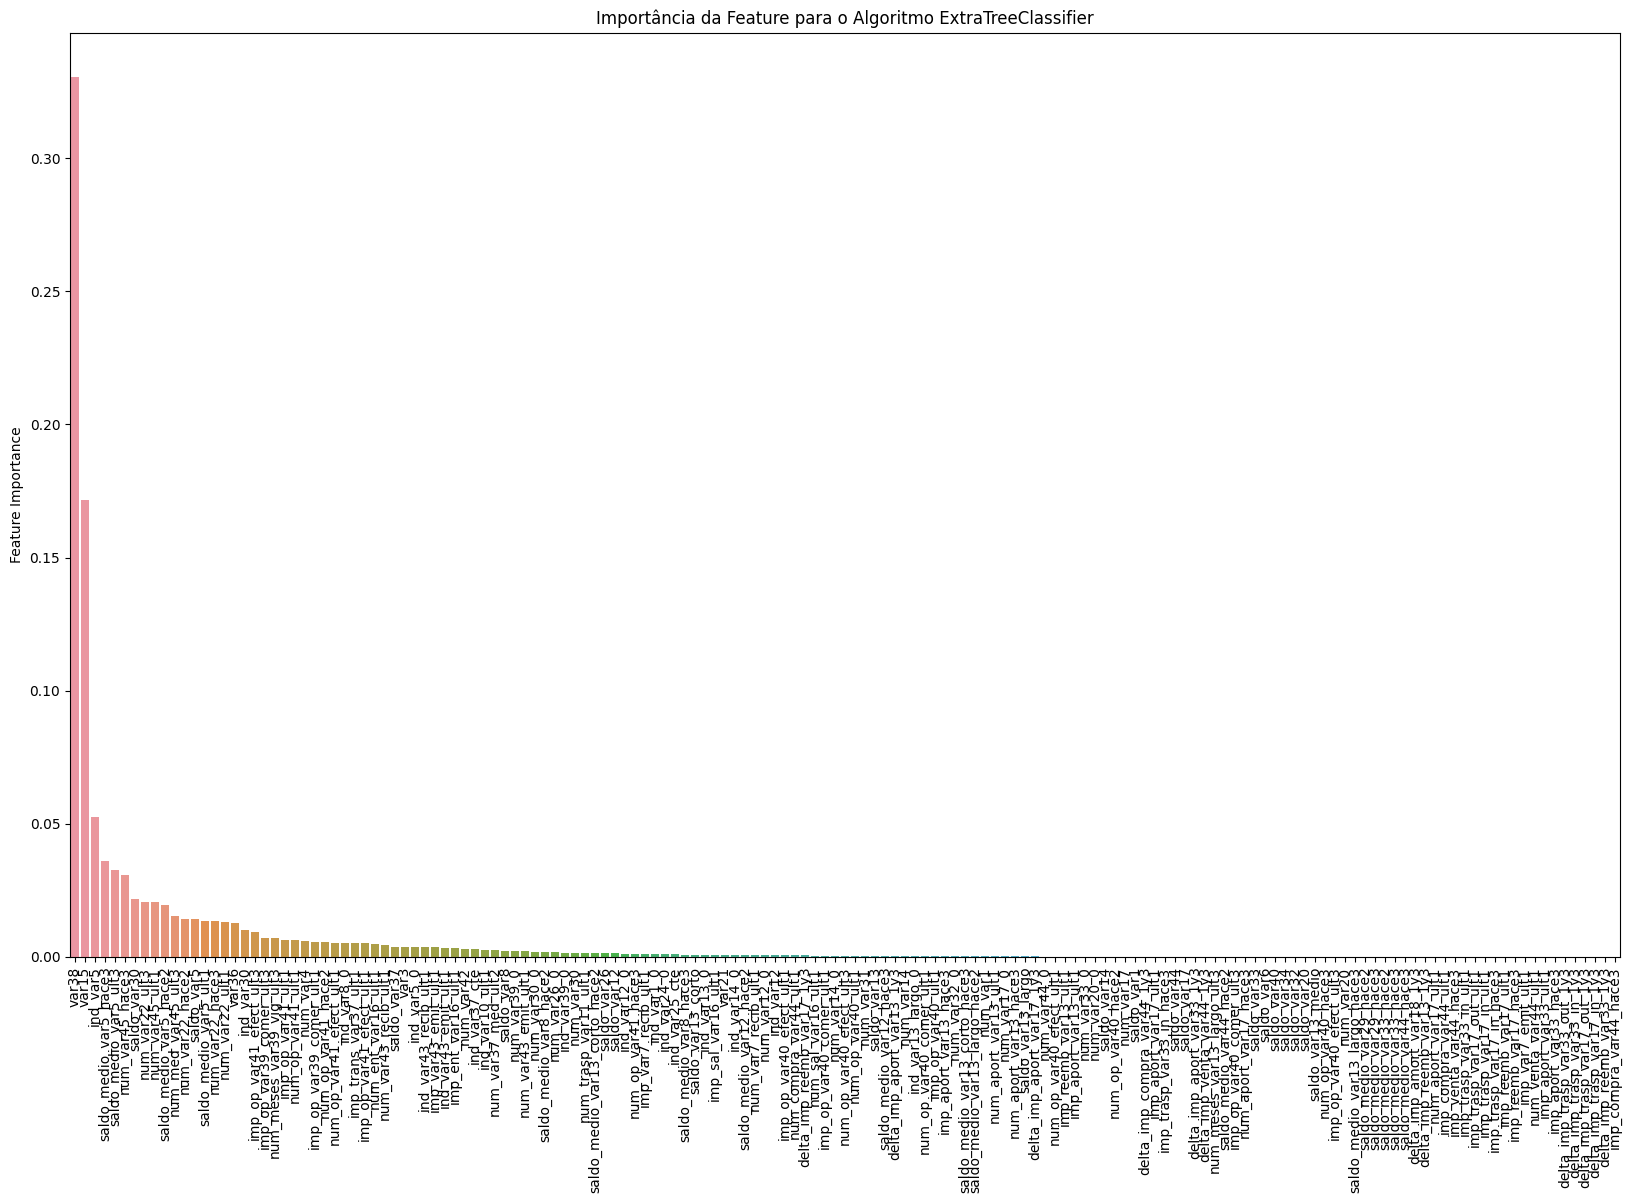

In [25]:
plt.figure(figsize=(20,12))
sns.barplot(data = plot, x=plot.index, y = 'Feature Importance')
plt.title('Importância da Feature para o Algoritmo ExtraTreeClassifier')
plt.xticks(rotation = 90);

In [26]:
# Remove as features com zero importância
df_importance = df_imp.loc[df_imp['Feature Importance'] != 0]

df_importance

,Feature Importance
var3,0.003741
var15,0.171683
imp_ent_var16_ult1,0.003224
imp_op_var39_comer_ult1,0.005427
imp_op_var39_comer_ult3,0.007158
...,...
saldo_medio_var13_corto_hace2,0.001391
saldo_medio_var13_corto_hace3,0.000122
saldo_medio_var13_largo_hace2,0.000111
saldo_medio_var44_hace2,0.000004


In [27]:
X_train_sel3 = X_train_sel2[df_importance.index]

X_train_sel3

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_ult1,imp_op_var41_efect_ult1,...,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var44_hace2,var38
0,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,39205.170000
1,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,300.0,122.22,0.0,0.0,49278.030000
2,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,67333.770000
3,2.0,37.0,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,138.84,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,64007.970000
4,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13501.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,60926.490000
76016,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,15498.42,0.0,0.0,0.00,0.0,0.0,118634.520000
76017,2.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,74028.150000
76018,2.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.58,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,84278.160000


Após 3 técnicas de Feature Extraction, sobraram 119 features consideradas importantes.

Para reduzir ainda mais a dimensionalidade, será feita uma comparação do uso de diferentes quantidades de features.

In [28]:
for i in [1, 2, 3, 4, 5, 10]:
    selected_features = df_importance.iloc[:df_importance.shape[0]//i,:].index
    x_train = X_train[selected_features].values
    RF_model = RandomForestClassifier()
    scores = cross_val_score(RF_model, x_train, y_train, cv=5, scoring='roc_auc')

    print(f"ROC AUC: {scores.mean()} (+/- {scores.std()}), {len(selected_features)} features utilizadas.")

ROC AUC: 0.7543525942781226 (+/- 0.012804304655185972), 119 features utilizadas.
ROC AUC: 0.7693315847786153 (+/- 0.013164348584891003), 59 features utilizadas.
ROC AUC: 0.7690555132489375 (+/- 0.016159733176562364), 39 features utilizadas.
ROC AUC: 0.7693745411288162 (+/- 0.01737486627857514), 29 features utilizadas.
ROC AUC: 0.7739165253609379 (+/- 0.015871271744270235), 23 features utilizadas.
ROC AUC: 0.7025525384497253 (+/- 0.0160861750256168), 11 features utilizadas.


A utilização de 23 features obteve a maior média de ROC AUC, apesar do desvio padrão ser um pouco maior que o uso de 60 features. No entanto, a menor dimensionalidade também é vantajosa em tempo de treinamento e explicabilidade do modelo, então serão adotadas 23 features para o modelo final.

In [30]:
num_features = 23
selected_features = df_importance.iloc[:num_features,:].index

selected_features

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_ult1', 'imp_op_var41_efect_ult1',
       'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_sal_var16_ult1',
       'ind_var1_0', 'ind_var5_0', 'ind_var5', 'ind_var8_0', 'ind_var12_0',
       'ind_var12', 'ind_var13_0', 'ind_var13_largo_0', 'ind_var14_0',
       'ind_var24_0'],
      dtype='object')

In [31]:
x_train = X_train[selected_features].values

In [32]:
x_train.shape

(76020, 23)

Agora, será realizado o treinamento de alguns diferentes modelos, considerando diferentes técnicas de Pré-Processamento e diferentes algoritmos.

# Variável target - Desbalanceamento de classes

Quando os dados possuem muito mais registros de uma das classes de saída que de outras, os modelos de Machine Learning podem aprender mais sobre aquela classe do que as outras, e então ter performances muito diferentes para cada uma das classes. Algumas técnicas para lidar com desbalanceamento de classe incluem a eliminação de registros da classe majoritária com _undersamplers_, geração de dados sintéticos com _oversamplers_, como o SMOTE, que será usado mais adiante, ou mesmo o ajuste de algum parâmetro em algoritmos mais robustos a esse tipo de problema.

O presente conjunto de dados sofre de desbalanceamento de classes, como pode ser visto no gráfico:

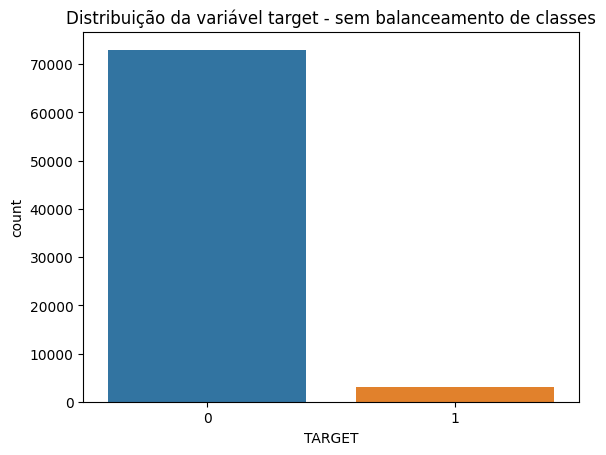

In [33]:
sns.countplot(x = y_train)
plt.title('Distribuição da variável target - sem balanceamento de classes');

A aplicação de um oversampler, como o SMOTE, pode ser a solução para equilibrar as classes minoritária e majoritária. No entanto, outras técnicas também serão testadas. 

O gráfico abaixo ilustra o funcionamento do SMOTE.

In [34]:
# Aplicação de SMOTE
oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(x_train, y_train)

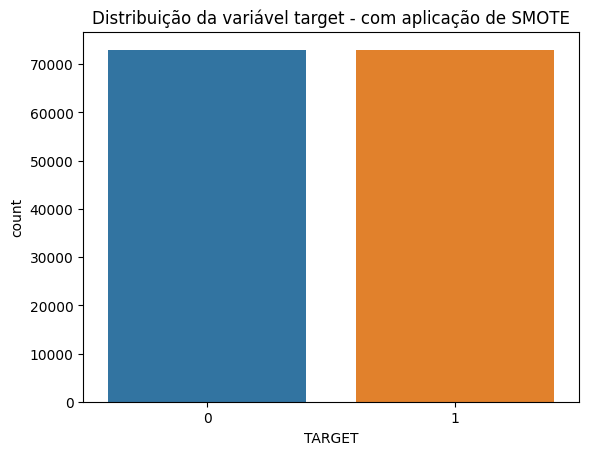

In [35]:
sns.countplot(x = y_resample)
plt.title('Distribuição da variável target - com aplicação de SMOTE');

# Pipeline de Machine Learning

Há diferentes técnicas de pré-processamento e diferentes modelos de Machine Learning que podem ser utilizados. Serão testadas algumas combinações, incluindo uso de:

*Pré-Processamento:*

* Padronização
* Normalização

*Balanceamento de classes:*

* SMOTE

*Modelos de Machine Learning:*
* RandomForestClassifier
* XGBoostClassifier
* Linear Discriminant Analysis

In [36]:
def train_and_score_model(model, x, y, scale = False, normalize = False, smote = False):
# Função que recebe o tipo de algoritmo 
    
    # Exception
    if scale and normalize:
        raise Exception("Choose either scale or normalize.")
    
    # Escolha do Pipeline
    if scale:
        if smote:
            pipeline = make_pipeline(StandardScaler(), SMOTE(), model)
        else:
            pipeline = make_pipeline(StandardScaler(), model)
    elif normalize:
        if smote:
            pipeline = make_pipeline(MinMaxScaler(), SMOTE(), model)
        else:
            pipeline = make_pipeline(MinMaxScaler(), model)
    else:
        pipeline = make_pipeline(model)
    
    # Fit
    fitted_model = pipeline.fit(x, y)
    
    # Scoring
    scores = cross_val_score(fitted_model, x_train, y_train, cv=5, scoring='roc_auc')
    
    # Dict
    model_dict = {"Modelo": model, 
                  "Scale": scale,
                  "Normalize": normalize,
                  "SMOTE": smote,
                  "ROC AUC": scores.mean()}
    
    for key, value in model_dict.items():
        print(f"{key}: {value}\n")
    
    # Dataframe
    model_df = pd.DataFrame([model_dict])
    
    return fitted_model, model_df

In [37]:
def validation_score(model, x, y):
    predictions = model.predict(x)
    return roc_auc_score(y, predictions) 

In [38]:
# Cópia dos dados de treino
pre_split_x_train = x_train.copy()
pre_split_y_train = y_train.copy()

# Divisão em dados de treino e validação
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

## Modelo 1 - Random Forest

In [39]:
model1, model_df1 = train_and_score_model(RandomForestClassifier(), x_train, y_train)

Modelo: RandomForestClassifier()

Scale: False

Normalize: False

SMOTE: False

ROC AUC: 0.7720269978674172



## Modelo 2 - Random Forest + Scale

In [40]:
model2, model_df2 = train_and_score_model(RandomForestClassifier(), x_train, y_train, scale = True)

Modelo: RandomForestClassifier()

Scale: True

Normalize: False

SMOTE: False

ROC AUC: 0.7708307391575404



## Modelo 3 - Random Forest + Scale + SMOTE

In [41]:
model3, model_df3 = train_and_score_model(RandomForestClassifier(), x_train, y_train, scale = True, smote = True)

Modelo: RandomForestClassifier()

Scale: True

Normalize: False

SMOTE: True

ROC AUC: 0.7513863824596795



## Modelo 4 - Random Forest + Normalize

In [42]:
model4, model_df4 = train_and_score_model(RandomForestClassifier(), x_train, y_train, normalize = True)

Modelo: RandomForestClassifier()

Scale: False

Normalize: True

SMOTE: False

ROC AUC: 0.7719958749343313



## Modelo 5- Random Forest + Normalize + SMOTE

In [43]:
model5, model_df5 = train_and_score_model(RandomForestClassifier(), x_train, y_train, normalize = True, smote = True)

Modelo: RandomForestClassifier()

Scale: False

Normalize: True

SMOTE: True

ROC AUC: 0.7644270585493491



## Modelo 6 - XGBoost

In [44]:
model6, model_df6 = train_and_score_model(XGBClassifier(), x_train, y_train)

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Scale: False

Normalize: False

SMOTE: False

ROC AUC: 0.7965771940437412



O modelo XGBoost, mesmo sem scaling, normalizing ou SMOTE já obteve um desempenho de ROC AUC em Cross-Validation melhor que em todas os modelos do Random Forest. 

É preciso testar com o dataset de validação para garantir que não há overfitting.

In [45]:
validation_score(model6, x_valid, y_valid)

0.5006759185420355

O ROC AUC em validação está muito mais baixo que o do cross-validation. Isso significa que o modelo está com overfitting. O XGBoost possui alguns parâmetros que podem ajudar a evitar esse problema.

O parâmetro scale_pos_weight é geralmente ajustado para o valor da proporção entre a classe positiva (1) e a classe negativa (0) da variável target. Isso não só evita o overfitting, como evita a necessidade de utilizar uma técnica de oversampling, como o SMOTE.

In [46]:
# Conta as ocorrências dos valores 0 e 1, respectivamente, na variável target
np.bincount(pre_split_y_train)

array([73012,  3008], dtype=int64)

In [47]:
# Verifica a proporção da ocorrência dos valores 0 e 1, respectivamente, na variável target
np.bincount(pre_split_y_train) / len(pre_split_y_train) # 96 / 4 = 24

array([0.96043147, 0.03956853])

## Modelo 7 - XGBoost com ajuste no parâmetro scale_pos_weight

In [48]:
model7, score7 = train_and_score_model(XGBClassifier(scale_pos_weight=24), x_train, y_train, scale = True)

Modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Scale: True

Normalize: False

SMOTE: False

ROC AUC: 0.7686650077425448



In [49]:
validation_score(model7, x_valid, y_valid)

0.7139379987260699

Com o ajuste no scale_pos_weight, foi possível melhorar o ROC AUC em validação e também evitar a necessidade do SMOTE.

Será testado mais um algoritmo antes de partir para a otimização de hiperparâmetros.

## Modelo 8 - Linear Discriminant Analysis

In [50]:
model8, score8 = train_and_score_model(LinearDiscriminantAnalysis(), x_train, y_train)

Modelo: LinearDiscriminantAnalysis()

Scale: False

Normalize: False

SMOTE: False

ROC AUC: 0.7770481044957405



O ROC AUC do modelo Linear Discriminant Analysis foi bastante próximo ao do XGBoost.

Será verificada a métrica em validação.

In [51]:
validation_score(model8, x_valid, y_valid)

0.5020182262279131

O modelo novamente sofre de overfitting. Pode-se aplicar Scale e SMOTE para tentar tornar o modelo mais generalizável.

## Modelo 9 - Linear Discriminant Analysis + Scale + SMOTE

In [52]:
model9, score9 = train_and_score_model(LinearDiscriminantAnalysis(), x_train, y_train, scale = True, smote = True)

Modelo: LinearDiscriminantAnalysis()

Scale: True

Normalize: False

SMOTE: True

ROC AUC: 0.7798872013696647



In [53]:
validation_score(model9, x_valid, y_valid)

0.6928123260257896

A resposta do modelo foi bem melhor, mas ainda foi inferior à performance do XGBoost.

O modelo XGBoost será escolhido para o modelo final, após otimização dos hiperparâmetros.

## Modelo 10 - XGBoost com Otimização de Hiperparâmetros

In [54]:
param_grid = {"max_depth": range(3,8,1),
              "gamma": [0, 0.1, 0.2, 0.3],
              "n_estimators": range(100,600,100),
              "learning_rate": [0.1, 0.2, 0.3, 0.5, 0.7, 1]}
    
gs = GridSearchCV(XGBClassifier(scale_pos_weight=24), param_grid = param_grid, scoring='roc_auc')

start = time.time()
modelo_final = gs.fit(x_train, y_train)

print("GridSearchCV executou em %.2f segundos para todas as combinações de candidatos a parâmetros do modelo."
      % (time.time() - start))

GridSearchCV executou em 8301.68 segundos para todas as combinações de candidatos a parâmetros do modelo.


In [55]:
# Verifica os melhores parâmetros
modelo_final.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [56]:
# ROC AUC em Cross-Validation
modelo_final.best_score_

0.8075490935796841

In [57]:
# ROC AUC em Validação
validation_score(modelo_final, x_valid, y_valid)

0.7374463553395558

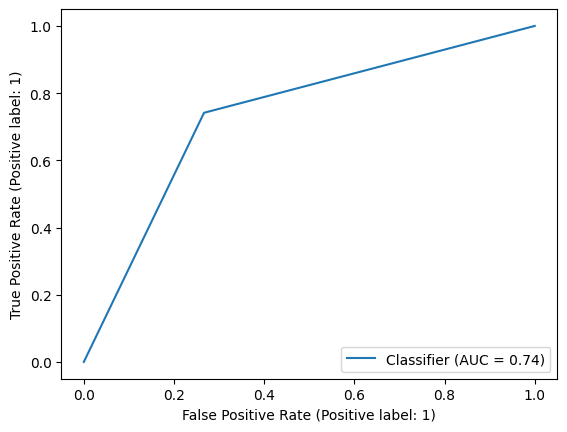

In [58]:
# Plot da ROC AUC
RocCurveDisplay.from_predictions(y_valid, modelo_final.predict(x_valid));

O ROC AUC é de mais de 70%, como era requerimento do projeto, com isso pode-se utilizar o modelo para fazer previsões e entregar o resultado.

# Prevendo o dataset teste e entregando o resultado

Com o modelo pronto, agora é possível fazer a previsão no dataset teste, que não possui a variável target. Todas as transformações que foram feitas no dataset de treino precisam ser feitas no dataset de teste.

Como o modelo final não utilizou de nenhuma técnica de pré-processamento, como scaling ou normalização, não é preciso aplicar essas transformações aos dados. Só é preciso selecionar as variáveis escolhidas durante a _Feature Selection_.

In [59]:
# Lê o dataset de teste
df_test = pd.read_csv("test.csv")

In [60]:
# Cria o DataFrame entregável
submission_df = pd.DataFrame()
submission_df['ID'] = df_test['ID']
submission_df = submission_df.set_index('ID')

# Remove variável ID
df_test = df_test.drop(['ID'], axis=1)

# Extrai a input com as features selecionadas
df_test = df_test[selected_features] 

# Previsões
predictions = modelo_final.predict_proba(df_test.values)

# Dataframe entregável
submission_df['TARGET'] = predictions[:,1]
submission_df.to_csv('submission.csv')